In [217]:
%autosave 0

Autosave disabled


In [218]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import lfilter
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import logistic, circmean, vonmises, circstd 
import uncertainties as unc
from uncertainties import unumpy as unp
import random
import time

In [219]:
def connectivity(n, modes):
    """Creates a (``n`` x ``n``) connectivity matrix for the ring neural field model.

    :param int n: number of rate neurons/population.
    :param collections.Iterable[float] modes: amplitude of the modes of connectivity ordered from 0 to n_modes.
    :return: connectivity matrix.
    :rtype: np.ndarray
    """
    
    [i_n, j_n] = np.meshgrid(range(n), range(n))
    ij = (i_n - j_n) * (2.0 * np.pi / n)

    jphi = 0
    for k, mode in enumerate(modes):
        if k == 0:
            jphi = mode
        else:
            jphi += 2.0 * mode * np.cos(k * ij)

    return jphi 

In [220]:
# Transfer function (scalar)

def sigmoid_pw(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, scalar version.

    :param float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: float
    """
    
    if isinstance(x, (list, np.ndarray)):
        return sigmoid_pw_v(x, a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    if x <= 0.0:
        return a * gamma / tau
    elif 0.0 < x < 1.0:
        return (a + x ** 2.0) * gamma / tau
    else:
        return (a + 2.0 * np.sqrt(x - 3.0 / 4.0)) * gamma / tau

In [221]:
# Transfer function (vectorial)

def sigmoid_pw_v(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, vectorial version.
    
    :param np.ndarray of float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: np.ndarray of float
    """
    
    if not isinstance(x, (list, np.ndarray)):
        return sigmoid_pw(float(x), a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    phi = x * 1.0
    # Conditions:
    m1 = (x <= 0.0)
    m3 = (x >= 1.0)
    m2 = ~(m1 | m3)
    # Function
    phi[m1] = a
    phi[m2] = a + x[m2] ** 2
    phi[m3] = a + 2.0 * np.sqrt(x[m3] - 3.0 / 4.0)

    return phi * gamma / tau 

In [222]:
def ou_process(dt, nsteps, mu, sigma, tau, trials=1, n_spatial=1, seed=None):
    """ Generates a good approximation of a single(or trials) Ornstein-Uhlenbeck process(es)
        for a single(oumodes) units.

    :param float dt: integration time-step.
    :param int nsteps: number of time steps.
    :param float mu: offset of the processs.
    :param float sigma: standard deviation of the process.
    :param float tau: time scale of the process (< dt).
    :param int trials: number of processes to be generated (trials).
    :param int n_spatial: number of spatially distributed units or modes of Fourier.
    :param int or None seed: seed for the random number generator.
    :return: time series: array (nsteps x trials x oumodes).
    :rtype: np.ndarray
    """
    
    # Constants
    a = np.exp(-dt / tau)
    b = mu * (1.0 - a)
    c = sigma * np.sqrt(1.0 - a ** 2)

    if seed is not None:
        np.random.seed(seed)

    s = lfilter(np.ones(1), [1, -a], b + c * np.random.randn(nsteps, trials, n_spatial), axis=0)
    return s

In [223]:
def compute_phase(x, n, c=(0.0,), s=(0.0,), wavenumber=1):
    """ Function that gives an approximate value of the phase of a spatial profile by projecting the vector x
    into a cosine function.

    :param Cython.Includes.numpy.ndarray x: firing rates matrix (or vector) with shape (d1, d2, ..., n).
    :param int n: spatial dimension (spatial discretization).
    :param np.ndarray of float c: cosine function, precompute it for faster computation.
    :param np.ndarray of float s: sine function, precompute it for faster computation.
    :param int wavenumber: wavenumber of the corresponding phase that we want to compute.
    :rtype: np.ndarray of float
    """

    # Check external cosine and sine functions
    if len(c) != n or len(s) != n:
        c = np.cos(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)
        s = np.sin(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)

    # norm of sine and cosine functions depends on n (discretization of the space)
    return np.arctan2((np.dot(x, s) / (n / 2.0) ** 2), (np.dot(x, c) / (n / 2.0) ** 2))

In [224]:
def equalbins(x, nbins):
    """ Computes the binning vector of a given data vector `x` categorized in equal proportion in `nbins`.

    :param np.ndarray x: vector of data to be binned.
    :param int nbins: number of bins.
    :return: a vector with the bins corresponding to each data point.
    :rtype: np.ndarray
    """
    
    quantiles = np.quantile(x, np.array(range(1, nbins)) / nbins)
    edges = np.concatenate(([-np.inf], quantiles, [np.inf]))
    return np.digitize(x, edges)

In [225]:
def compute_estimation(dataframe, nbins=41, ylabel='theta_est', **kwargs):
    """ Computes the estimation curve given an angular binning with `nbins` bins.
    
    :param pd.DataFrame dataframe: data-frame containing the circular mean of the stimulus orientation along with
                                   its estimation by the model.
    :param int nbins: number of bins to divide the angular range and perform the average across trials.
    :param str ylabel: label of the outcome column in the data-frame.
    :param kwargs: additional keyword arguments.
    :return: Returns a tuple (binning: average stimulus orientation, average estimation, standard error).
    :rtype: (pd.Series, pd.Series, pd.Series)
    """
    
    lim = kwargs.pop('lim', np.pi/2)
    # We define the categories for the data points and the model points/line
    dataframe['bin'] = equalbins(dataframe.theta, nbins)
    # Group the data by the binning and compute the circular mean of the stimulus orientation averages and the circular
    # mean of the estimated average orientations
    gr1 = dataframe.groupby('bin')
    x_avg = gr1.theta.apply(circmean, low=-np.pi, high=np.pi)
    y_avg = gr1[ylabel].apply(circmean, low=-np.pi, high=np.pi)
    y_std = gr1[ylabel].apply(circstd, low=-np.pi, high=np.pi)
    # Select the data inside the desired range
    s_x = x_avg.loc[np.abs(x_avg) <= lim]
    s_y = y_avg.loc[np.abs(x_avg) <= lim]
    s_e = y_std.loc[np.abs(x_avg) <= lim]
    return s_x, s_y, s_e

## Single trial

In [226]:
start = time.time()
# Define some variables

tstim = 2.05
nstim = 1
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring structure

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)
ntrials = 1

r = np.ones((rsteps, n)) * 0.1

i0 = 1.1  # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
theta_stim = 0 * np.pi / 180 # direcció angular del estímul

i_stim = 5E-3 * np.cos(theta - theta_stim)

#modes = [-1.0, 2.0, 0.2]
modes = [-2.0, 1.0, 0.5]
cnt = connectivity(n, modes)

mu, sigmaou, tau_ou = 0, 0.15, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n), seed=None

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < (tmax - dt):

    # Time step variables
    kp = tstep % rsteps #kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps #k is the -1 step
    
    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    if temps >= tmax/2:
        i_stim = i_stim*0.0
    #3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0
    tstep += 1
    temps = tstep * dt
r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))

phase = compute_phase(r, n)[-1]

end = time.time()
print("Real stimulus direction:", theta_stim * 180 / np.pi % 360)
print("Phase of the bump:", phase * 180 / np.pi % 360)
print("Time elapsed:", end - start)

Real stimulus direction: 0.0
Phase of the bump: 19.11580334768116
Time elapsed: 0.6100099086761475


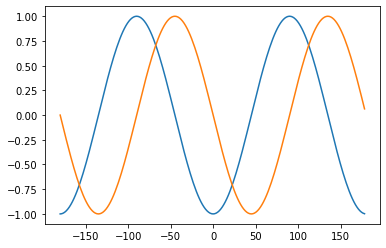

In [227]:
plt.plot(theta*180/np.pi, np.cos(2*(theta-np.pi/2))); plt.plot(theta*180/np.pi, np.sin(2*(theta-np.pi/2)))
plt.show()

In [228]:
# Prueba 1

start = time.time()
# Define some variables

tstim = 2.05
nstim = 1
tmax = nstim * tstim  # Maximum time
    
i_stim = 5E-3 * np.cos(2*(theta - theta_stim))
#i_stim = 5E-3 * abs(np.cos(theta))

mu, sigmaou, tau_ou = 0, 0.15, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n) seed=None

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < (tmax - dt):

    # Time step variables
    kp = tstep % rsteps #kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps #k is the -1 step

    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    #if temps >= tmax/2:
     #   i_stim = i_stim*0.0
    # 3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0
    tstep += 1
    temps = tstep * dt
r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))

phase = compute_phase(r, n)[-1]

end = time.time()
print("Real stimulus direction:", theta_stim * 180 / np.pi % 360)
print("Phase of the bump:", phase * 180 / np.pi % 360)
print("Time elapsed:", end - start)

Real stimulus direction: 0.0
Phase of the bump: 5.708843150489589
Time elapsed: 0.6193628311157227


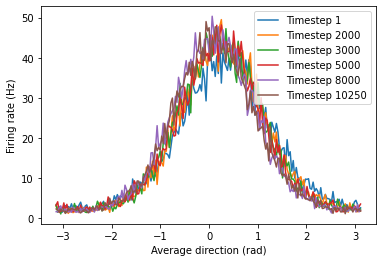

In [229]:
for i in [1, 2000, 3000, 5000, 8000, -1]:
    plt.plot(theta, r[i])
plt.legend(["Timestep 1","Timestep 2000", "Timestep 3000","Timestep 5000", "Timestep 8000", "Timestep 10250"], loc ="upper right")
plt.xlabel('Average direction (rad)')
plt.ylabel('Firing rate (Hz)')
plt.show()

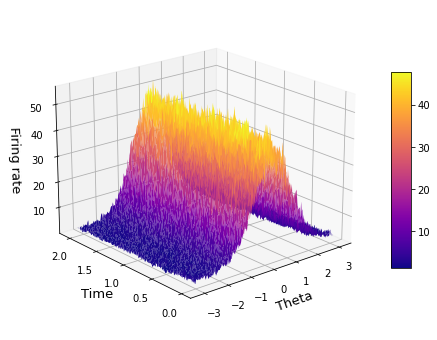

In [230]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = theta
y = tpoints
X,Y = np.meshgrid(x,y)
Z = r

surf1 = ax.plot_surface(X, Y, Z, cmap='plasma')

ax.view_init(20, 230)
#ax.set_title('Bump creation', fontsize=18)
ax.set_xlabel('Theta', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Firing rate' , fontsize=13, rotation=0)
ax.zaxis.set_label_coords(40, -10.025)

fig.colorbar(surf1, ax=ax, shrink=0.6, aspect=10)

plt.show()

## Arbitrary number of trials

In [743]:
df = pd.DataFrame(columns=['theta', 'theta_est'])

In [754]:
start = time.time()
# Define some variables

tstim = 2.05
nstim = 1
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring structure

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)
ntrials = 10

r = np.ones((rsteps, ntrials, n)) * 0.1
i0 = 1.08  # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)

#modes = [-1.0, 2.0, 0.2]
modes = [-2.0, 1.0, 0.5]
cnt = connectivity(n, modes)
dec_mode = 1

for i in range(50):
    theta_stim = np.random.uniform(-60 * np.pi / 180, 60 * np.pi / 180, ntrials) # angular direction of stimulus
    Theta, Theta_stim = np.meshgrid(theta, theta_stim)
    i_stim = 5E-3 * np.cos(Theta - Theta_stim) # + 2 * np.cos(theta_stim - theta)

    mu, sigmaou, tau_ou = 0, 0.15, 1E-3
    ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n) seed=None
    
    # Loop
    tstep = 0    
    temps = 0.0
    ttau = dt / tau

    while temps < (tmax - dt):

        # Time step variables
        kp = tstep % rsteps #kp is the 0 step
        k = (tstep + rsteps - 1) % rsteps #k is the -1 step

        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)

        #if temps >= tmax/2:
         #   i_stim = i_stim*0.0
            
        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0
        tstep += 1
        temps = tstep * dt
    r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))

    if dec_mode == 1: 
        
        # Reset some variables
        tmax = 2.05
        temps = 0.0

        i_stim = 5E-3 * np.cos(2*(Theta - np.pi/2))
        #i_stim = 5E-3 * abs(np.cos(theta))
        
        while temps < (tmax - dt):

            # Time step variables
            kp = tstep % rsteps #kp is the 0 step
            k = (tstep + rsteps - 1) % rsteps #k is the -1 step

            # 2. Presynaptic inputs
            s = 1.0 / n * np.dot(r[k], cnt)

            #if temps >= tmax/2:
             #   i_stim = i_stim*0.0

            # 3. Integration
            try:
                r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
            except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
                r[r < 1E-12] = 0.0
            tstep += 1
            temps = tstep * dt
        r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))

    phase = compute_phase(r, n)[-1]
    df = pd.concat([df, pd.DataFrame({'theta':theta_stim, 'theta_est': phase})], axis=0, levels=None, ignore_index=True)
    if i % 20 == 0: print(i)
    
end = time.time()
print("Time elapsed:", end - start)

0
20
40
Time elapsed: 111.73856997489929


In [755]:
# Edit DataFrame 

conditions = [
    (df['theta_est'] >= 0),
    (df['theta_est'] < 0)]
values = ['CW', 'CCW']
df['choice'] = np.select(conditions, values)

conditions = [
    (df['choice'] == 'CW'),
    (df['choice'] == 'CCW')]
values = [1, 0]
df['choice_bin'] = np.select(conditions, values)

bins = equalbins(df['theta_est'], 21)
sx, sy, ss = compute_estimation(df, nbins=11, lim=np.sqrt(3)/2)
[sx, sy, ss] = [np.rad2deg(k) for k in [sx, sy, ss]]

df

,theta,theta_est,choice,choice_bin,bin
0,0.419799,0.323481,CW,1,8
1,0.676146,0.684368,CW,1,9
2,0.745288,0.569832,CW,1,10
3,-0.603855,-0.628174,CCW,0,3
4,-0.972399,-1.147109,CCW,0,1
...,...,...,...,...,...
4495,-0.905348,-0.701539,CCW,0,1
4496,0.328549,-0.032361,CCW,0,8
4497,-0.913407,-0.799515,CCW,0,1
4498,-0.934227,-0.555658,CCW,0,1


In [756]:
df2 = pd.DataFrame({'theta':theta, 
                    'theta_est': (((df.groupby(pd.cut(df['theta'],np.append(theta, [np.pi])))
                                    .mean()).fillna(0)).values)[:,1]})
df2['mult'] = df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi]))).size().fillna(0).values
df2['prob'] = (df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi]))).mean().fillna(0).values)[:,2]
df2['std'] = (df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi]))).std()).fillna(0).loc[:,'theta_est'].values

df2

,theta,theta_est,mult,prob,std
0,-3.141593,0.0,0,0.0,0.0
1,-3.110177,0.0,0,0.0,0.0
2,-3.078761,0.0,0,0.0,0.0
3,-3.047345,0.0,0,0.0,0.0
4,-3.015929,0.0,0,0.0,0.0
...,...,...,...,...,...
195,2.984513,0.0,0,0.0,0.0
196,3.015929,0.0,0,0.0,0.0
197,3.047345,0.0,0,0.0,0.0
198,3.078761,0.0,0,0.0,0.0


No handles with labels found to put in legend.


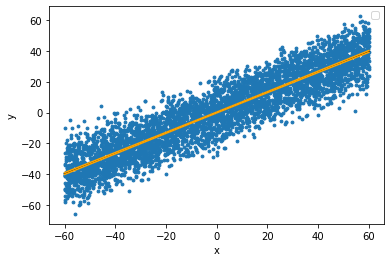

In [757]:
x = (df.loc[0:len(df), ['theta']].values)[:,0] * 180 / np.pi
y = (df.loc[0:len(df), ['theta_est']].values)[:,0] * 180 / np.pi
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)

# plot data
plt.scatter(x, y, s=8)

# calculate regression confidence interval
px = np.linspace(-60, 60, 100)
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

# plot the regression
plt.plot(px, nom, c='black')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='orange')
plt.plot(px, nom + 1.96 * std, c='orange')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

# save and show figure
plt.show()

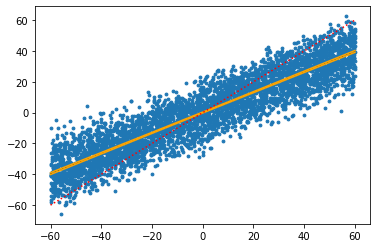

In [758]:
x = (df.loc[0:len(df), ['theta']].values)[:,0] * 180 / np.pi
y = (df.loc[0:len(df), ['theta_est']].values)[:,0] * 180 / np.pi
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)
#popt, pcov = curve_fit(f, sx, sy)

# retrieve parameter values
a = popt[0]
b = popt[1]

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))
#n2 = len(sy)
#r2 = 1.0-(sum((sy-f(sx,a,b))**2)/((n2-1.0)*np.var(sy,ddof=1)))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)

fig, ax = plt.subplots()
# plot data
ax.scatter(x, y, s=8, label='Data')

# calculate regression confidence interval
px = np.linspace(-60, 60, 100)
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

# plot the regression
ax.plot(px, nom, ':', c='black', label='y=a x + b')

# uncertainty lines (95% confidence)
ax.plot(px, nom - 1.95 * std, c='orange',
         label='95% Confidence Region')
ax.plot(px, nom + 1.95 * std, c='orange')
ax.fill_between(px, nom - 1.95 * std, nom + 1.95 * std, color='orange', alpha=.1)

x = np.linspace(-60, 60, 100)
y = x 
ax.plot(x, y, ':r');  # dotted red

In [759]:
ss

bin
2     10.691062
3      9.746417
4     10.283332
5      9.484145
6     10.838544
7      9.807637
8     10.456131
9     10.171485
10    10.465151
Name: theta_est, dtype: float64

In [760]:
df2['mult'][100:200]

100    63
101    57
102    73
103    77
104    74
       ..
195     0
196     0
197     0
198     0
199     0
Name: mult, Length: 100, dtype: int64

In [761]:
df2

,theta,theta_est,mult,prob,std
0,-3.141593,0.0,0,0.0,0.0
1,-3.110177,0.0,0,0.0,0.0
2,-3.078761,0.0,0,0.0,0.0
3,-3.047345,0.0,0,0.0,0.0
4,-3.015929,0.0,0,0.0,0.0
...,...,...,...,...,...
195,2.984513,0.0,0,0.0,0.0
196,3.015929,0.0,0,0.0,0.0
197,3.047345,0.0,0,0.0,0.0
198,3.078761,0.0,0,0.0,0.0


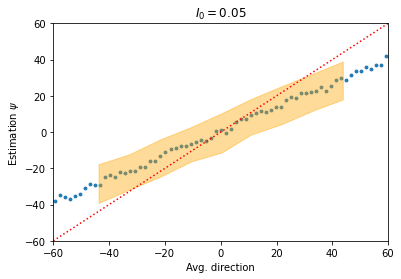

In [762]:
# Estimació vs. average direction (circular mean)

x = (df2.loc[0:len(df2), ['theta']].values)[:,0] * 180 / np.pi
y = (df2.loc[0:len(df2), ['theta_est']].values)[:,0] * 180 / np.pi
n = len(y)

# plot data
plt.scatter(x, y, s=8, label='Data')

# uncertainty lines (95% confidence)
plt.fill_between(sx, sy + ss, sy - ss, color='orange', alpha=0.4)

x = np.linspace(-60, 60, 100)
y = x 
plt.axis([-60, 60, -60, 60])
plt.title("$I_0=0.05$")
plt.xlabel("Avg. direction")
plt.ylabel("Estimation $\psi$")
plt.plot(x, y, ':r')
plt.show()

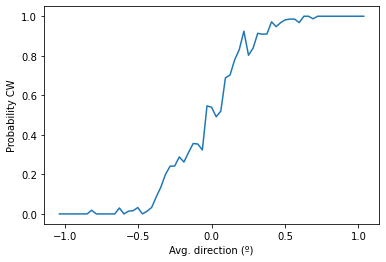

In [763]:
x = df2.loc[0:len(df2), ['theta']].values[abs(df2.loc[0:len(df2), ['theta']].values)<60*np.pi/180]
y = np.take(a=df2.loc[0:len(df2), ['prob']].values, 
        indices=np.where(abs(df2.loc[0:len(df2), ['theta']])<60*np.pi/180)[0], axis=0)[:,0]
plt.plot(x, y);
plt.xlabel("Avg. direction (º)")
plt.ylabel("Probability CW")
plt.show()

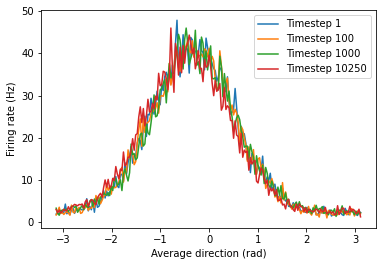

In [562]:
for i in [1, 100, 2500, -1]:
    plt.plot(theta, r[i, 0])
plt.legend(["Timestep 1", "Timestep 100", "Timestep 1000", "Timestep 10250"], loc ="upper right")
plt.xlabel('Average direction (rad)')
plt.ylabel('Firing rate (Hz)')
plt.show()

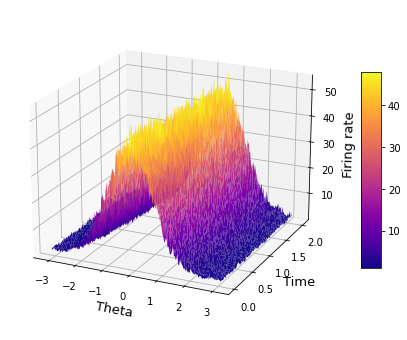

In [313]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = theta
y = tpoints
X,Y = np.meshgrid(x,y)
Z = r[:,0,:]

#ax.set_title('Bump creation', fontsize=18)
    
surf1 = ax.plot_surface(X, Y, Z, cmap='plasma')

ax.view_init(20, 295)
ax.set_xlabel('Theta', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Firing rate' , fontsize=13, rotation=0)
ax.zaxis.set_label_coords(40, -10.025)

fig.colorbar(surf1, ax=ax, shrink=0.6, aspect=10)

plt.show()

In [ ]:
#https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics